In [1]:
import sys
from sys import meta_path

from pyarrow import scalar
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, precision_recall_curve

sys.path.append('../')

from fwc2.utils import load_data

In [9]:
[10**-i for i in range(1, 4)]

[0.1, 0.01, 0.001]

In [2]:
import pandas as pd
import numpy as np
import os

seed = 42

# data = [(d, load_data(d, raw=False)) for d in datasets]
# datasets = ['dapt20', 'scvic21']
datasets = ['dapt20']

results = [] 
for d in datasets:
    train_set = pd.read_csv(f'../data/{d}/anomaly/train.csv')
    test_set = pd.read_csv(f'../data/{d}/anomaly/test.csv')
    
    train_X, train_y = train_set.drop(columns='label'), train_set['label']
    test_X, test_y = test_set.drop(columns='label'), test_set['label']
    
    test_y = test_y.apply(lambda x: 0 if x == 'benign' else 1)
    
    scaler = StandardScaler()
    scaler.fit(train_X)
    
    train_X = scaler.transform(train_X)
    test_X = scaler.transform(test_X)
    
    # models = [('o-svm', OneClassSVM(kernel='rbf', nu=0.1)), ('if', IsolationForest(n_estimators=50, contamination=0.1, random_state=seed))]
    models = [('if', IsolationForest(n_estimators=200, n_jobs=2, random_state=seed)), ('oc-svm', OneClassSVM())]
    for type, model  in models:
        model.fit(train_X)
        
        anomaly_scores = model.decision_function(test_X)
        preds = np.where(model.predict(test_X) == -1, 1, 0)
        
        precision = precision_score(test_y, preds)
        recall = recall_score(test_y, preds)
        f1 = f1_score(test_y, preds)
        auc = roc_auc_score(test_y, -anomaly_scores)
        
        results.append((d, type, model, precision, recall, f1, auc))
    

In [3]:
for results in results:
    dataset, type, mode, precision, recall, f1, auc = results
    
    print(f'result of {type} on {dataset}')
    print(f' ** precision = {precision}')
    print(f' ** recall = {recall}')
    print(f' ** f1 = {f1}')
    print(f' ** auc = {auc}')

result of if on dapt20
 ** precision = 0.21343283582089553
 ** recall = 0.01244614648157013
 ** f1 = 0.023520703976314814
 ** auc = 0.5918419955397437
result of oc-svm on dapt20
 ** precision = 0.6186803253992166
 ** recall = 0.4467992514904913
 ** f1 = 0.5188760297164805
 ** auc = 0.3692069760431561


In [30]:
len(train_set), len(test_set)

(50970, 35721)

In [65]:
test_y_b = test_y.apply(lambda v: 0 if v == 'benign' else 1) 

for pred in predictions:
    name, type, preds, scores, p = pred
    
    preds = pd.Series(preds).replace([-1,1],[1,0])
    
    fpr, tpr, threshold = roc_curve(test_y_b, scores)
    roc_auc = auc(fpr, tpr)
    
    accuracy = accuracy_score(test_y_b, preds)
    precision = precision_score(test_y_b, preds)
    recall = recall_score(test_y_b, preds)
    f1 = f1_score(test_y_b, preds)
    
    
    print(f'{name} , model = {type} , auc = {roc_auc}, accuracy = {accuracy}, f1 = {f1}, recall = {recall}, precision = {precision}')
    # print(scores)
    # print(preds)

dapt20 , model = o-svm , auc = 0.8291352089887316, accuracy = 0.26673385403544136, f1 = 0.07605206532858302, recall = 0.04691239827668741, precision = 0.20074487895716947
dapt20 , model = if , auc = 0.5280215311819069, accuracy = 0.6016068979031942, f1 = 0.7363604364660331, recall = 0.8648766264850516, precision = 0.6410967741935484


In [67]:
test_set['label'].value_counts()

label
benign                12742
reconnaissance        11909
establish foothold     8604
lateral movement       2451
data exfiltration        15
Name: count, dtype: int64

(315607, 70)


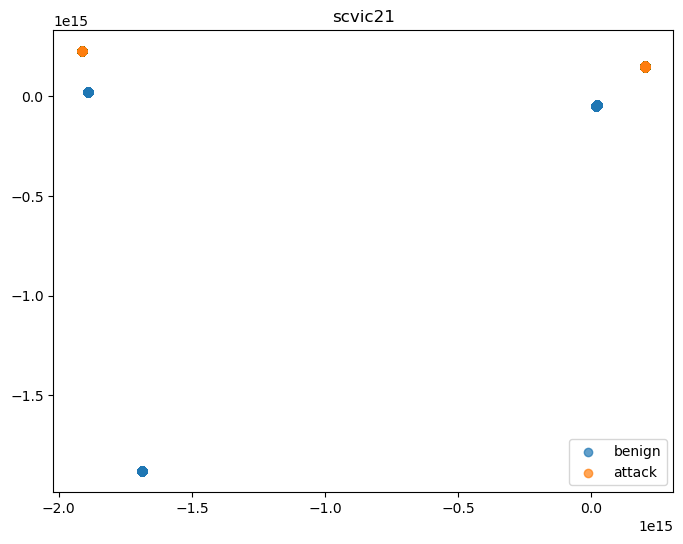

In [79]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

for dataset in ['scvic21']:
    train_set = pd.read_csv(f'../data/{dataset}/anomaly/train.csv')
    test_set = pd.read_csv(f'../data/{dataset}/anomaly/test.csv')
    
    all = pd.concat([train_set, test_set], ignore_index=True)
    
    print(f'{all.shape}')
    
    features = all.drop(columns=['label'])
    target = all['label'].apply(lambda v: 0 if v == 'benign' else 1)
    
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(features)
    
    plt.figure(figsize=(8, 6))
    for label in [0, 1]:
        plt.scatter(
            reduced_data[target == label, 0],
            reduced_data[target == label, 1],
            label="attack" if label == 1 else 'benign',
            alpha=0.7
        )
    
    plt.title(f"{dataset}")
    # plt.xlabel("Principal Component 1")
    # plt.ylabel("Principal Component 2")
    plt.legend()
    # plt.grid(True)
    plt.show()

In [24]:

roc_auc

0.8291352089887316

In [25]:
threshold

array([           inf, 6.95751009e+02, 6.72713448e+02, ...,
       6.01971806e-11, 5.57065505e-12, 0.00000000e+00])

In [27]:
precision_recall_curve(test_y_b, scores)

(array([0.64329106, 0.64348922, 0.64350724, ..., 0.        , 0.        ,
        1.        ]),
 array([1., 1., 1., ..., 0., 0., 0.]),
 array([0.00000000e+00, 5.57065505e-12, 7.61701813e-12, ...,
        6.91528491e+02, 6.95129149e+02, 6.95751009e+02]))

In [82]:
import torch
from torch.distributions import Normal, Uniform


unifom_dist = Uniform(torch.tensor([0.1]), torch.tensor([6]))
# distribution = Normal(0, 1)
corruption_rate = 0.8
x = torch.rand(1, 5)

rand_t = torch.rand_like(x, device=x.device)
corruption_mask = rand_t > corruption_rate

x_random = unifom_dist.sample(torch.Size((x.shape[0],))).to(x.device)
x_corrupted = torch.where(corruption_mask, x_random, x)
x_corrupted_compliment =  torch.where(~corruption_mask, x_random, x)

x, rand_t,  corruption_mask, x_corrupted, x_corrupted_compliment

(tensor([[0.0796, 0.2125, 0.1674, 0.7100, 0.6119]]),
 tensor([[0.3790, 0.0696, 0.4124, 0.9731, 0.8914]]),
 tensor([[False, False, False,  True,  True]]),
 tensor([[0.0796, 0.2125, 0.1674, 1.4889, 1.4889]]),
 tensor([[1.4889, 1.4889, 1.4889, 0.7100, 0.6119]]))

In [54]:
x1 = torch.randn(5, 2)
x2 = torch.randn(5, 2)

cos_sim = torch.nn.CosineSimilarity(dim=0)

sim = cos_sim(x1, x2)

In [55]:
sim

tensor([0.2634, 0.4531])

In [51]:
x1, x2

(tensor([[-0.0186,  0.4758],
         [-0.3809, -0.0865],
         [ 0.4651, -1.3722],
         [ 2.0565, -0.3956],
         [-0.6203, -0.1303]]),
 tensor([[-1.4515,  0.0637],
         [ 0.7288,  0.9812],
         [ 0.0018, -0.7437],
         [-1.2718,  0.7257],
         [ 0.7581,  0.0311]]))

In [53]:
cos_sim(x1, x2) , cos_sim(x2, x1)

(tensor([ 0.0829, -0.7592,  0.9479, -0.9465, -0.9862]),
 tensor([ 0.0829, -0.7592,  0.9479, -0.9465, -0.9862]))

In [99]:
def _find_net_arch(out_dim, num_hidden, factor=1.0):
    curr = out_dim
    archi = [curr]
    for i in range(num_hidden):
        curr = int(factor * curr)
        archi.append(curr)

    archi.reverse()

    return archi

In [117]:
_find_net_arch(64, 3, factor=2)

[512, 256, 128, 64]

In [89]:
from torchsummary import summary

In [110]:
from fwc2.model import MLP

model = MLP(16, _find_net_arch(8, 2, factor=2), 0.1)

In [111]:
print(model)

MLP(
  (0): Linear(in_features=16, out_features=32, bias=True)
  (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=32, out_features=16, bias=True)
  (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): Dropout(p=0.1, inplace=False)
  (8): Linear(in_features=16, out_features=8, bias=True)
  (9): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Dropout(p=0.1, inplace=False)
  (12): Linear(in_features=8, out_features=8, bias=True)
)


In [112]:
out = model(torch.randn(100, 16))

In [113]:
out.shape

torch.Size([100, 8])

In [123]:
v = 64 / 2

v

32.0

In [55]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', context='notebook')

def tsne_scatter(features, labels, dimensions=2, save_as='graph.png'):
    if dimensions not in (2, 3):
        raise ValueError('tsne_scatter can only plot in 2d or 3d (What are you? An alien that can visualise >3d?). Make sure the "dimensions" argument is in (2, 3)')

    # t-SNE dimensionality reduction
    features_embedded = TSNE(n_components=dimensions, random_state=42).fit_transform(features)
    
    # initialising the plot
    fig, ax = plt.subplots(figsize=(8,8))
    
    # counting dimensions
    if dimensions == 3: ax = fig.add_subplot(111, projection='3d')

    # plotting data
    ax.scatter(
        *zip(*features_embedded[np.where(labels==1)]),
        marker='o',
        color='r',
        s=3,
        alpha=0.7,
        label='Attack'
    )
    ax.scatter(
        *zip(*features_embedded[np.where(labels==0)]),
        marker='o',
        color='b',
        s=3,
        alpha=0.3,
        label='Benign'
    )

    # storing it to be displayed later
    plt.legend(loc='best')
    plt.savefig(save_as)
    plt.show()

In [86]:
data = test_set = pd.read_csv(f'../data/scvic21/anomaly/test.csv')
data.shape

(67272, 70)

In [57]:
data['label'] = data['label'].apply(lambda x: 0 if x == 'benign' else 1)

In [87]:
sample = data.sample(frac=1)
sample['label'] = sample['label'].apply(lambda x: 0 if x == 'benign' else 1)

sample.shape

(67272, 70)

In [88]:
sample.label.value_counts() / len(data)

label
0    0.92288
1    0.07712
Name: count, dtype: float64

In [52]:
import torch 
sample_tensor = torch.randn(100, 8)

sample_tensor.numpy().shape, sample['label'][:100].shape

((100, 8), (100,))

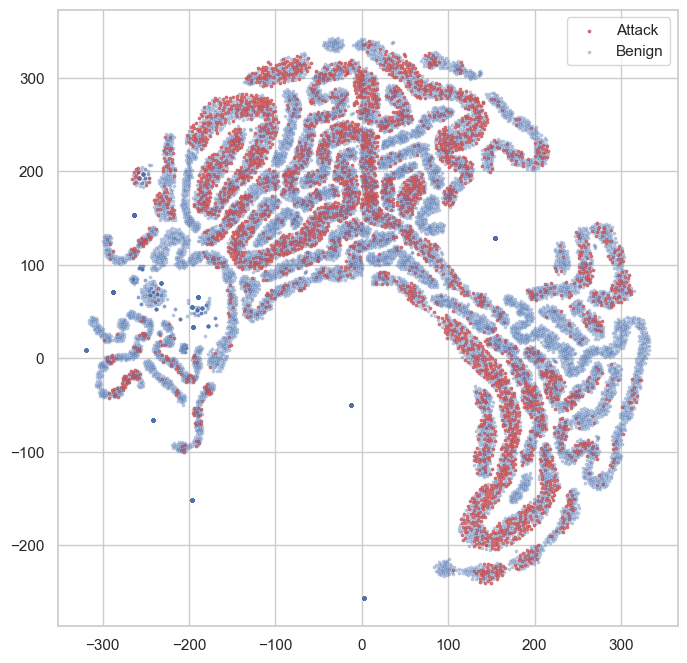

In [89]:
tsne_scatter(sample.drop(columns=['label']), sample['label'], dimensions=2, save_as='sample-scvic21-testset-anomaly-tsne.png')
# tsne_scatter(sample_tensor.numpy(), sample['label'][:100], dimensions=2, save_as='sample-scvic21-testset-anomaly-tsne.png')

In [92]:
for item in {'dapt20': (5, 64), 'scvic21': (6, 69)}.items():
    ds, shape = item 
    print(ds)
    print(shape[0])
    print(shape[1])

dapt20
5
64
scvic21
6
69


In [25]:
import torch
from torch import nn

conv1 = nn.LazyConsv1d(out_channels=10, kernel_size=3)
conv2 = nn.LazyConv1d(out_channels=20, kernel_size=6)

# m = nn.Conv1d(in_channels=1, out_channels=2, kernel_size=2)
input = torch.randn(10, 1, 64)
output = conv1(input)

C:\Users\client\Projects\PhD\FWC2L\.envs\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [26]:
output.shape

torch.Size([10, 10, 62])

In [27]:
output

tensor([[[-0.1220,  0.3074,  0.0895,  ...,  0.5944,  0.7571, -0.4884],
         [ 0.1781,  0.1421,  0.1561,  ...,  1.3971,  1.3486,  0.3624],
         [-0.2838, -0.0281,  0.0176,  ..., -1.1944, -1.0025, -0.7884],
         ...,
         [-0.7280, -0.5047, -0.3435,  ..., -0.2307, -0.0552, -1.1062],
         [ 0.6376, -0.1322,  0.1802,  ...,  0.3276, -0.0163,  1.4666],
         [-0.6368, -0.0693, -0.7419,  ...,  0.1127,  0.2011, -0.8605]],

        [[ 0.3550,  0.0801, -0.3411,  ...,  0.1739,  0.4242,  0.5340],
         [ 0.9180,  0.4363, -0.3646,  ...,  1.0019,  0.9850,  0.6039],
         [-0.8101, -0.4980,  0.0814,  ..., -0.8366, -1.0103, -0.2628],
         ...,
         [-0.3960, -0.6715, -1.0430,  ..., -0.2370, -0.6187, -0.1260],
         [ 0.3744,  0.5055,  0.6429,  ...,  0.6842,  0.3782, -0.2305],
         [-0.1378, -0.3064, -0.6349,  ..., -0.7329,  0.3150, -0.1438]],

        [[ 0.5102,  1.2507,  0.5916,  ...,  0.0186,  0.2694, -0.9827],
         [ 1.6568,  1.9749,  1.7520,  ...,  0

In [28]:
out2 = conv2(output)

In [29]:
out2.shape

torch.Size([10, 20, 57])

In [ ]:
nn.AvgPool1d()

In [13]:
torch.randperm(10)

tensor([8, 6, 4, 1, 0, 7, 2, 3, 9, 5])

In [14]:
x = torch.rand(4, 3)

x

tensor([[0.6213, 0.6275, 0.8045],
        [0.2893, 0.3011, 0.7165],
        [0.5608, 0.7080, 0.4388],
        [0.9426, 0.3019, 0.5530]])

In [15]:
m, n = x.shape
x_bar = torch.zeros_like(x)

x_bar, m, n

(tensor([[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]),
 4,
 3)

In [16]:
for i in range(n):
    idx = torch.randperm(m)
    x_bar[:, i] += x[idx, i]
    print(x_bar)

tensor([[0.6213, 0.0000, 0.0000],
        [0.9426, 0.0000, 0.0000],
        [0.2893, 0.0000, 0.0000],
        [0.5608, 0.0000, 0.0000]])
tensor([[0.6213, 0.3019, 0.0000],
        [0.9426, 0.7080, 0.0000],
        [0.2893, 0.3011, 0.0000],
        [0.5608, 0.6275, 0.0000]])
tensor([[0.6213, 0.3019, 0.5530],
        [0.9426, 0.7080, 0.8045],
        [0.2893, 0.3011, 0.7165],
        [0.5608, 0.6275, 0.4388]])


In [18]:
# corrupt_x = x * (1.0 - mask) + x_bar * mask

p_mat = torch.ones_like(x) * 0.5
torch.bernoulli(p_mat), p_mat

(tensor([[1., 0., 0.],
         [1., 1., 1.],
         [0., 1., 0.],
         [0., 0., 0.]]),
 tensor([[0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000]]))